## 대시보드 그래프 시각화
커널 선택: http://4.230.26.44:8888

### Spark session 생성

In [1]:
import os
import sys

sys.path.append("/app")
from src.utils.spark_builder import get_spark_session
from pyspark.sql import functions as F

os.environ[
    "PYSPARK_SUBMIT_ARGS"
] = """
    --conf spark.cores.max=2
    --conf spark.executor.memory=8g
    --conf spark.app.name=GDELT_gold_visualization
    pyspark-shell
"""

# Spark 세션 생성
spark = get_spark_session("GDELT_gold_visualization", "spark://spark-master:7077")
print("✅ Spark 세션 생성 완료")

25/09/26 17:03:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


✅ Spark 세션 생성 완료


### 데이터베이스 연결 확인

In [2]:
print("📜 사용 가능한 gold_dev 스키마의 테이블 목록:")
spark.sql("SHOW TABLES IN gold_dev").show()

📜 사용 가능한 gold_dev 스키마의 테이블 목록:


+---------+--------------------+-----------+
|namespace|           tableName|isTemporary|
+---------+--------------------+-----------+
| gold_dev|gold_chart_events...|      false|
| gold_dev|gold_chart_events...|      false|
| gold_dev|gold_chart_weekda...|      false|
| gold_dev|gold_daily_actor_...|      false|
| gold_dev|gold_daily_detail...|      false|
| gold_dev|gold_near_realtim...|      false|
+---------+--------------------+-----------+



### 그래프를 위한 환경 설정 → 커널 재시작 시, 최초 1회 필수 실행

In [3]:
# 노트북 세션을 새로 시작할 때마다 이 셀을 가장 먼저 실행해주세요.
# 0단계: 모든 필수 Python 라이브러리 설치
import sys
import os

print("시각화에 필요한 라이브러리를 설치합니다.")
!{sys.executable} -m pip install -q matplotlib seaborn squarify
print("✅ Python 시각화 라이브러리(matplotlib, seaborn, squarify) 설치 완료.")

# 모든 라이브러리 임포트
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import squarify
import pandas as pd
from pyspark.sql.functions import col, date_format, sum as spark_sum
from matplotlib.ticker import FuncFormatter

# 1단계: 시스템 패키지 목록 업데이트 및 한글 폰트 설치
print("\n시스템 패키지 목록을 최신 상태로 업데이트합니다.")
os.system("apt-get -qq update")
print("나눔고딕 폰트 설치를 시작합니다.")
os.system("apt-get -qq -y install fonts-nanum")
print("✅ 폰트 설치 완료.")

# 2단계: Matplotlib 폰트 캐시 재구성 및 설정
print("\nMatplotlib의 폰트 캐시를 재구성하고 폰트를 등록합니다.")
try:
    # 폰트 캐시를 직접 삭제하여 재구성 유도
    import matplotlib

    cache_dir = matplotlib.get_cachedir()
    if os.path.exists(cache_dir):
        os.system(f"rm -rf {cache_dir}/*")

    # 폰트 경로를 직접 지정하여 강제 등록
    font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
    if os.path.exists(font_path):
        fm.fontManager.addfont(font_path)

    # Matplotlib 기본 폰트 설정
    plt.rc("font", family="NanumGothic")
    plt.rcParams["axes.unicode_minus"] = False
    print("✅ Matplotlib 한글 폰트 설정이 성공적으로 완료되었습니다.")

except Exception as e:
    print(f"❌ 폰트 설정 중 오류 발생: {e}")

시각화에 필요한 라이브러리를 설치합니다.

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
✅ Python 시각화 라이브러리(matplotlib, seaborn, squarify) 설치 완료.

시스템 패키지 목록을 최신 상태로 업데이트합니다.
나눔고딕 폰트 설치를 시작합니다.
✅ 폰트 설치 완료.

Matplotlib의 폰트 캐시를 재구성하고 폰트를 등록합니다.
✅ Matplotlib 한글 폰트 설정이 성공적으로 완료되었습니다.


### 이벤트 분류별 분포 시각화 : gold_chart_events_category
1. 이벤트 카테고리별 분포 (가로 막대그래프)
2. 이벤트 타입(4대 분류)별 분포 (트리맵)

'gold_dev.gold_chart_events_category' 테이블에서 데이터를 불러옵니다.


25/09/26 17:03:50 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties
25/09/26 17:03:55 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


✅ 데이터 로딩 및 변환 완료.

[그래프 1] '이벤트 카테고리별 분포' 막대그래프 시각화를 시작합니다.


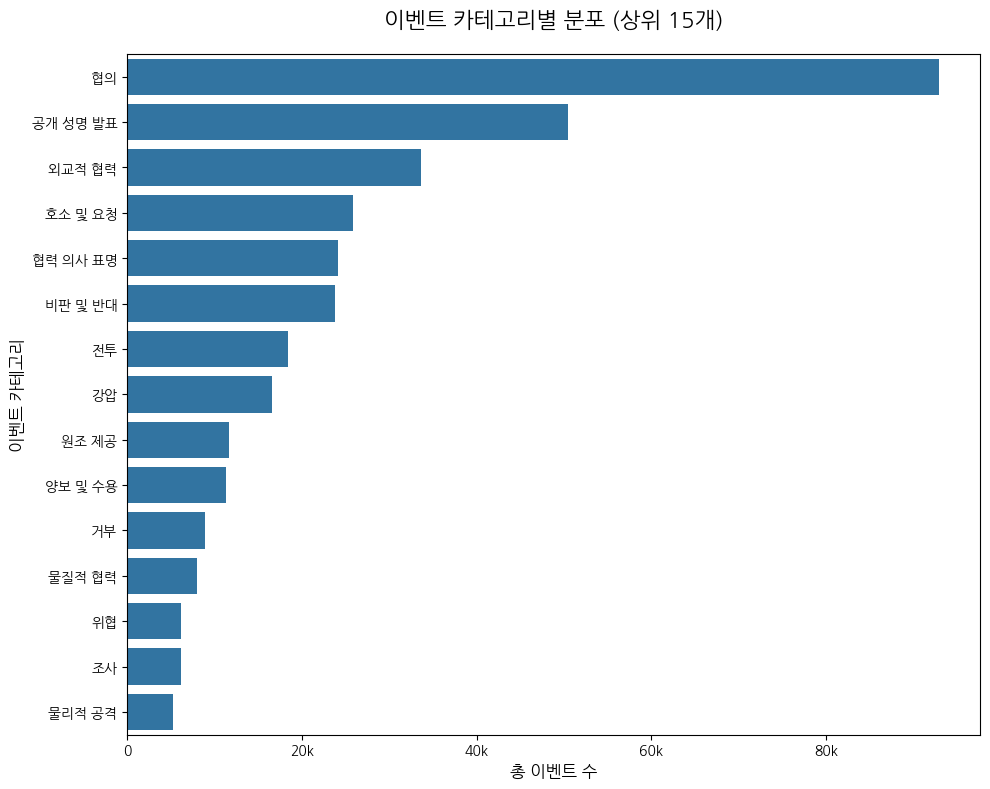

✅ 막대그래프 생성 완료.

[그래프 2] '이벤트 타입 분포' 트리맵 시각화를 시작합니다.


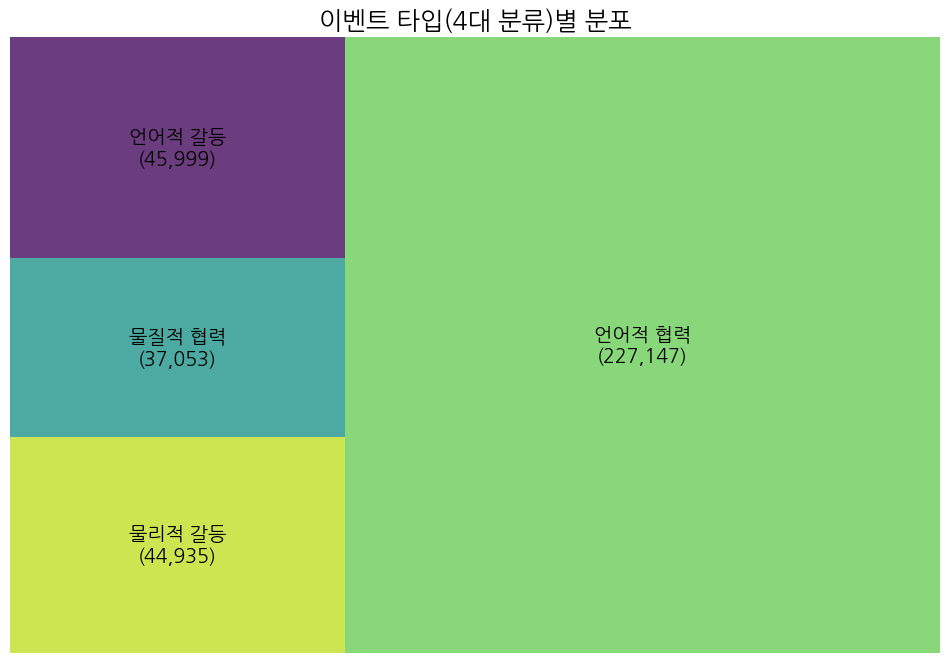

✅ 트리맵 생성 완료.


In [4]:
try:
    table_name = "gold_dev.gold_chart_events_category"
    print(f"'{table_name}' 테이블에서 데이터를 불러옵니다.")
    df = spark.table(table_name)

    # 시각화에 필요한 컬럼만 선택하여 Pandas로 변환 (날짜 타입 변환 오류 방지)
    pandas_df = df.select(
        "mp_quad_class", "mp_event_categories", "event_count"
    ).toPandas()
    print("✅ 데이터 로딩 및 변환 완료.")

    # 그래프 1: 카테고리 별 이벤트 분포 (가로 막대그래프)
    print("\n[그래프 1] '이벤트 카테고리별 분포' 막대그래프 시각화를 시작합니다.")

    category_agg = (
        pandas_df.groupby("mp_event_categories")["event_count"].sum().reset_index()
    )
    category_agg = category_agg.sort_values(by="event_count", ascending=False).head(15)

    plt.figure(figsize=(10, 8))
    barplot = sns.barplot(
        x="event_count", y="mp_event_categories", data=category_agg, orient="h"
    )
    plt.title("이벤트 카테고리별 분포 (상위 15개)", fontsize=16, pad=20)
    plt.xlabel("총 이벤트 수", fontsize=12)
    plt.ylabel("이벤트 카테고리", fontsize=12)

    def format_k(x, pos):
        return f"{x*1e-3:,.0f}k" if x > 0 else "0"

    formatter = FuncFormatter(format_k)
    barplot.xaxis.set_major_formatter(formatter)

    plt.tight_layout()
    plt.show()
    print("✅ 막대그래프 생성 완료.")

    # 그래프 2: 이벤트 타입 분포 (트리맵)
    print("\n[그래프 2] '이벤트 타입 분포' 트리맵 시각화를 시작합니다.")

    quad_class_agg = (
        pandas_df.groupby("mp_quad_class")["event_count"].sum().reset_index()
    )

    sizes = quad_class_agg["event_count"]
    labels = quad_class_agg.apply(
        lambda x: f"{x['mp_quad_class']}\n({x['event_count']:,})", axis=1
    )

    plt.figure(figsize=(12, 8))
    squarify.plot(sizes=sizes, label=labels, alpha=0.8, text_kwargs={"fontsize": 14})

    plt.title("이벤트 타입(4대 분류)별 분포", fontsize=18)
    plt.axis("off")
    plt.show()
    print("✅ 트리맵 생성 완료.")

except Exception as e:
    print(f"❌ 데이터를 불러오거나 시각화하는 중 오류가 발생했습니다: {e}")

### 요일별 이벤트 발생 비율 시각화 : gold_chart_weekday_event_ratio
3. 요일별 이벤트 발생 비율 (꺾은선 그래프): 기간별(지난 2년 vs 이번 달) 요일 패턴을 꺾은선 그래프로 비교

'gold_dev.gold_chart_weekday_event_ratio' 테이블에서 데이터를 불러옵니다.


✅ '대한민국' 데이터 로딩 및 필터링 완료.

[그래프 3] '대한민국'의 요일별 이벤트 발생 비율 그래프를 시각화합니다.


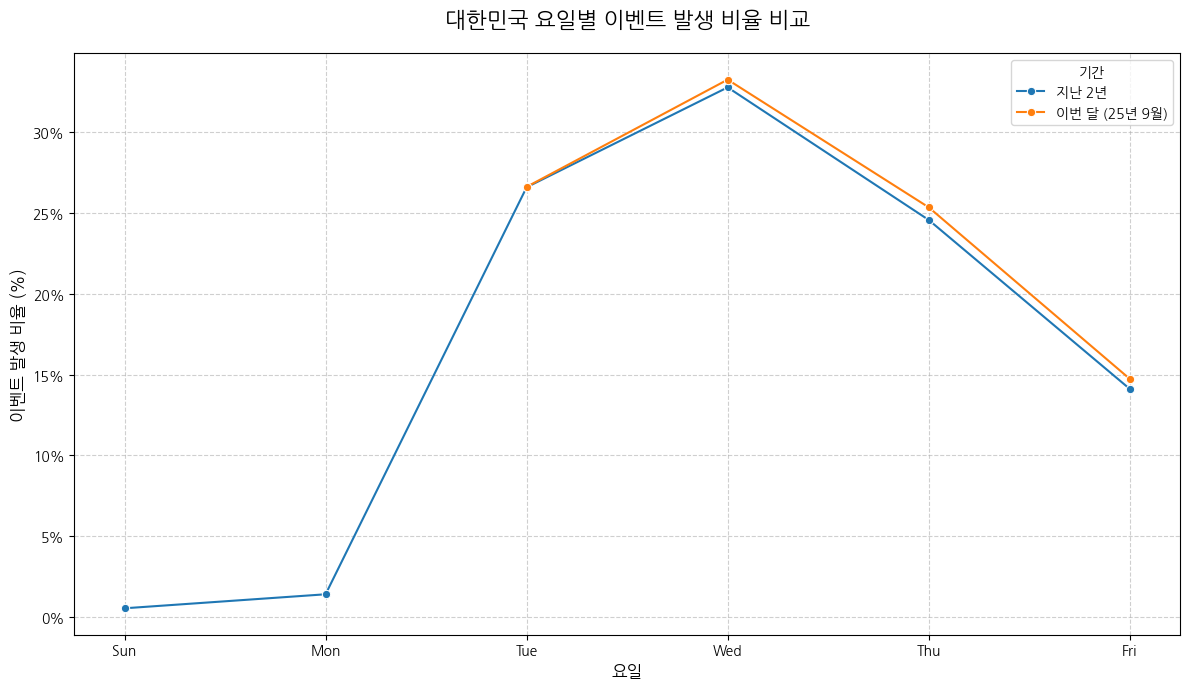

✅ 그래프 생성 완료.


In [5]:
try:
    table_name = "gold_dev.gold_chart_weekday_event_ratio"
    print(f"'{table_name}' 테이블에서 데이터를 불러옵니다.")
    pandas_df = spark.table(table_name).toPandas()

    country_to_visualize = "대한민국"
    df_filtered = pandas_df[
        pandas_df["mp_action_geo_country_kor"] == country_to_visualize
    ]
    df_sorted = df_filtered.sort_values(by="weekday_num")
    print(f"✅ '{country_to_visualize}' 데이터 로딩 및 필터링 완료.")

    print(
        f"\n[그래프 3] '{country_to_visualize}'의 요일별 이벤트 발생 비율 그래프를 시각화합니다."
    )

    plt.figure(figsize=(12, 7))
    sns.lineplot(
        data=df_sorted,
        x="weekday_name",
        y="event_percentage",
        hue="period",
        marker="o",
        sort=False,
    )

    plt.title(
        f"{country_to_visualize} 요일별 이벤트 발생 비율 비교", fontsize=16, pad=20
    )
    plt.xlabel("요일", fontsize=12)
    plt.ylabel("이벤트 발생 비율 (%)", fontsize=12)

    plt.gca().yaxis.set_major_formatter(FuncFormatter("{:.0f}%".format))
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend(title="기간")
    plt.tight_layout()
    plt.show()
    print("✅ 그래프 생성 완료.")

except Exception as e:
    print(f"❌ 데이터를 불러오거나 시각화하는 중 오류가 발생했습니다: {e}")

### 일별 이벤트 수 및 평균 톤 시각화 : gold_chart_events_count_avgtone
4. 일별 이벤트 수 및 평균 톤 추이 (꺾은선+막대 그래프)

'gold_dev.gold_chart_events_count_avgtone' 테이블에서 데이터를 불러옵니다.


✅ 데이터 로딩 및 변환 완료.

[그래프 4] 이벤트 수 및 기사 톤 추이 (꺾은선 + 막대)


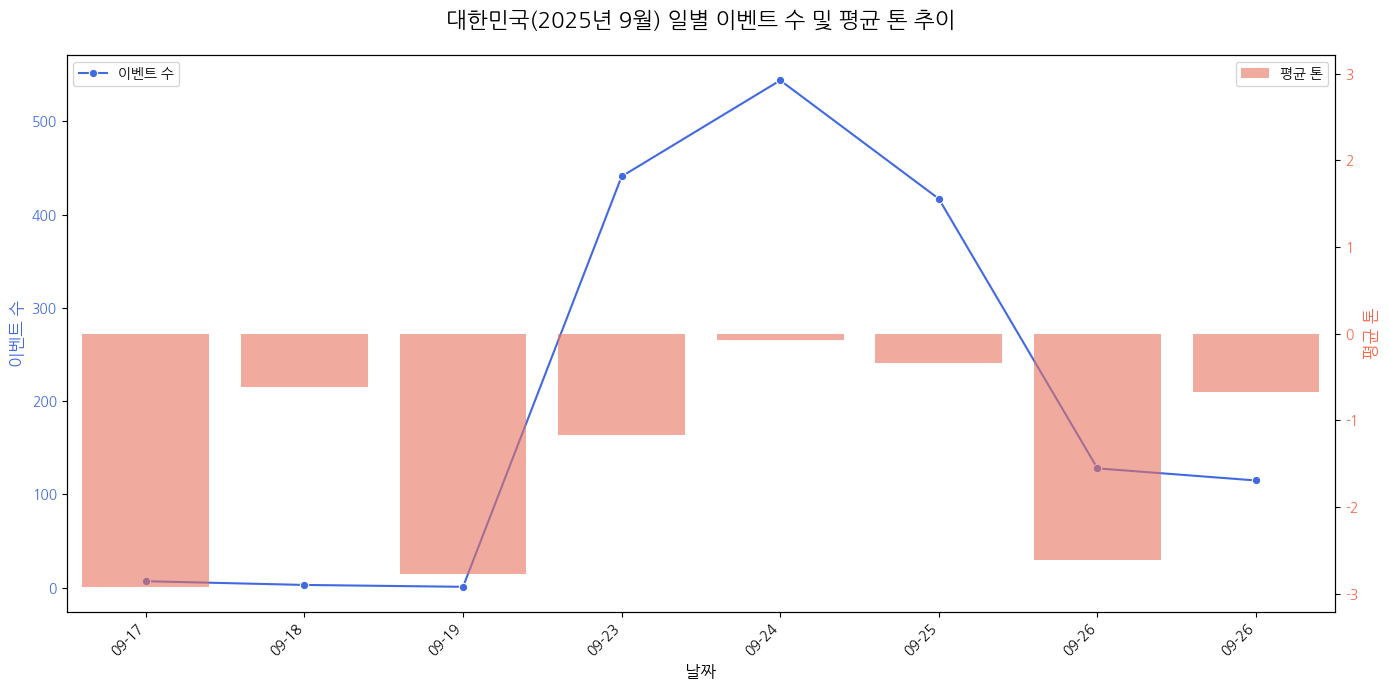

✅ 그래프 생성 완료.


In [6]:
try:
    table_name = "gold_dev.gold_chart_events_count_avgtone"
    print(f"'{table_name}' 테이블에서 데이터를 불러옵니다.")
    df = spark.table(table_name)

    # 날짜/시간 컬럼을 안전한 문자열로 변환
    df_safe_types = (
        df.withColumn("event_date_str", date_format(col("event_date"), "yyyy-MM-dd"))
        .withColumn(
            "processed_at_str", date_format(col("processed_at"), "yyyy-MM-dd HH:mm:ss")
        )
        .drop("event_date", "processed_at")
    )

    pandas_df = df_safe_types.toPandas()
    pandas_df["event_date"] = pd.to_datetime(pandas_df["event_date_str"])
    print("✅ 데이터 로딩 및 변환 완료.")

    print("\n[그래프 4] 이벤트 수 및 기사 톤 추이 (꺾은선 + 막대)")

    df_chart = pandas_df[
        (pandas_df.get("mp_action_geo_country_kor") == "대한민국")
        & (pandas_df["event_date"].dt.strftime("%Y-%m") == "2025-09")
    ].sort_values("event_date")

    if not df_chart.empty:
        x_axis = range(len(df_chart))

        fig, ax1 = plt.subplots(figsize=(14, 7))
        ax2 = ax1.twinx()

        sns.lineplot(
            x=x_axis,
            y="event_count",
            data=df_chart,
            ax=ax1,
            color="royalblue",
            marker="o",
            label="이벤트 수",
        )
        ax1.set_ylabel("이벤트 수", color="royalblue", fontsize=12)
        ax1.tick_params(axis="y", labelcolor="royalblue")
        ax1.legend(loc="upper left")

        if "avg_tone" in df_chart.columns:
            sns.barplot(
                x=x_axis,
                y="avg_tone",
                data=df_chart,
                ax=ax2,
                color="tomato",
                alpha=0.6,
                label="평균 톤",
            )
            ax2.set_ylabel("평균 톤", color="tomato", fontsize=12)
            ax2.tick_params(axis="y", labelcolor="tomato")
            ax2.legend(loc="upper right")

            max_abs_tone = df_chart["avg_tone"].abs().max()
            axis_limit = max_abs_tone * 1.1 if max_abs_tone > 0 else 1
            ax2.set_ylim(-axis_limit, axis_limit)

        ax1.set_xticks(x_axis)
        ax1.set_xticklabels(
            df_chart["event_date"].dt.strftime("%m-%d"), rotation=45, ha="right"
        )
        ax1.set_xlabel("날짜", fontsize=12)

        plt.title(
            "대한민국(2025년 9월) 일별 이벤트 수 및 평균 톤 추이", fontsize=16, pad=20
        )
        fig.tight_layout()
        plt.show()
        print("✅ 그래프 생성 완료.")
    else:
        print("시각화할 데이터가 없습니다. (대한민국, 2025년 9월)")

except Exception as e:
    print(f"❌ 데이터를 불러오거나 시각화하는 중 오류가 발생했습니다: {e}")

### Spark 세션 종료

In [ ]:
spark.stop()
print("\n✅ Spark 세션이 종료되었습니다.")